# SARIMA Modeling
---

In this notebook you will find a model and analysis of each of the selected campsites.

Each SARIMA model was trained using the pmdarima (pronounced "Pyramid") module, which is an emulation of R's Auto Arima functionality. It functions similarly to a 'grid search', and returns the best performing model according to its Bayesian and Akaike Information Criterions, BIC and AIC respectively. Additonally, as the limit to the data was between 0 and 1, representing percentage, I used a logarithmic transformation (https://otexts.com/fpp2/limits.html) to constrain the predictions in all but one of the models.

Each SARIMA model will be used to predict a 60 week forecast. Then, using half of the 60 week testing data, will update and predict a 30 week forecast. Some models were used to predict 104 week periods on unseen data as well to observe trends.

Each SARIMA model was evaluated using Mean Absolute Error (MAE), Root Mean Squared Error(RMSE), and a Forecast Bias Test.

- [**Import Libraries**](#Import-Libraries)
- [**Functions**](#Functions)
- [**Modeling**](#Modeling)
  - [Moraine Park, Rocky Mountain National Park](#Moraine-Park,-Rocky-Mountain-National-Park)
  - [Mather Campground, Grand Canyon National Park](#Mather-Campground,-Grand-Canyon-National-Park)
  - [Big Meadows, Shenandoah National Park](#Big-Meadows-Campground,-Shenadoah-National-Park)
  - [Upper Pines, Yosemite National Park](#Upper-Pines-Campground,-Yosemite-National-Park)
  - [Elkmont, Great Smoky Mountains National Park](#Elkmont-Campground,-Great-Smoky-Mountains-National-Park)


# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly as py
from chart_studio.plotly import plot_mpl
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error 

from pmdarima import arima
from pmdarima.arima import auto_arima
from pmdarima import pipeline, preprocessing as ppc, utils

%matplotlib inline

# Functions

In [2]:
def sarima_fit_predict (train, test, periods, endog_col = None, exog = None):
'''
Trains and predicts time series forecasts

Uses the pmdarima stepwise SARIMA fit to optimize for AIC and BIC

Also has functionality for adding exogenous variables and dynamically change to SARIMAX

Returns the stepwise model, predictions, and the confidence interval

''' 
    # functinality to specify the endogenous variable in a training set
    if endog_col:
        endog = train[endog_col]
        
    else:
        endog = train
    
    # check if an exogenous variable is provided, then run stepwise SARIMAX
    if isinstance(exog, pd.DataFrame):
        
        exog_test = test[exog.columns]
        
        # search for best hyperparameters using the auto ARIMA functionality
        model = auto_arima(endog, exogenous= exog, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True, n_jobs = -1)
        
        print(f"Final AIC: {model.aic()}")
        print(model)
        preds, conf_int = model.predict(n_periods = periods, exogenous = exog_test, return_conf_int = True)
    
    else:
        
        # run auto arima if no exognenous variable is provided
        model = auto_arima(endog, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True, n_jobs = -1)
        
        print(f"Final AIC: {model.aic()}")
        print(model)
        preds, conf_int = model.predict(n_periods = periods, return_conf_int = True)
    
    return model, preds, conf_int

In [3]:
# function to update a stepwise SARIMA model
def sarima_update(test, split, model):
    
        observed, val_test = test[:split], test[split:]
        model.update(observed, maxiter=10)

        preds, conf = model.predict(n_periods = val_test.shape[0], return_conf_int= True)

        return preds, conf, observed, val_test

In [4]:
# Function to update a stepwise SARIMAX model
def sarimax_update(endog, test, split, model, exog_cols):
    '''
    This version takes a dataframe for test, array for endog
    '''
    observed, val_test = test[:split], test[split:]
    val_exog = val_test[exog_cols]
    obs_exog = observed[exog_cols]
    
    stepwise_model.update(endog[:split], exogenous= obs_exog, maxiter=10)

    preds, conf = stepwise_model.predict(n_periods = val_test.shape[0], exogenous = val_exog, return_conf_int= True)

    return preds, conf, endog[:split], endog[split:]


In [5]:
# use plotly to plot chart of predictions and acutal values
def plotly_forecast(df, preds, train, test, title):
    
    # Create traces
    fig = go.Figure()
    
    n_train = train.shape[0]
    x = np.arange(n_train + preds.shape[0])
    
    fig.add_trace(go.Scatter(x= df.index[n_train:], y= preds,
                    mode='lines+markers',
                    name='Predicted'))

    fig.add_trace(go.Scatter(x= df.index[n_train:], y= test[:preds.shape[0]],
                    mode='lines+markers',
                    name='Actual'))

    # plot title
    fig.update_layout(title_text= title,
                  title_font_size= 16)
    
    fig.show()

In [6]:
def log_transformer(endog, lower = 0, upper = 1, floor = 1e-16, truncate = False, inverse = False):
    """Forces the ARIMA model to limit its predictions within the contraints provided
    Where x is the endogenous variable, a is the lower limit, and b is the upper limit:
    y = log((x-a)/(b-x))
    
    This also can reverse the transformation, with y being the transformed predictions:
    x  = ((b-a) * e^y) / (1 + e^y) + a.
    
    Methodology from:
    https://otexts.com/fpp2/limits.html
    """
    endog = endog + floor
    
    if inverse:
        
        return ((upper-lower) * np.exp(endog)) / (1 + np.exp(endog)) + lower
    
    else:
        
        if truncate:
            endog[endog <= 0] = floor
        
        y = np.log((endog - lower)/(upper - endog))
        y[np.isinf(y)] = upper
        
        return y

In [7]:
def time_series_metrics (preds, expected):
    '''
    Evaluates common time series metrics for predictions vs. expectations. 
    
    Forecast Bias is the expected value minus the predicted value, then takes the mean.
    
    A mean forecast error value other than zero suggests a 
    tendency of the model to over forecast (negative error) or under forecast (positive error).
    
    Methdology from:
    https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/
    '''
    forecast_errors = [expected[i]-preds[i] for i in range(len(expected))]
    bias = sum(forecast_errors) * 1.0/len(expected)
    print(f'Forecast Bias: {bias}')
    
    mae = mean_absolute_error(expected, preds)
    print(f'MAE: {mae}' )
    
    mse = mean_squared_error(expected, preds)
    print(f'RMSE: {np.sqrt(mse)}')

# Modeling
---

## Moraine Park, Rocky Mountain National Park
---
Moraine park exhibits a somewhat stationary 52-week seasonality, but shows more volatility than Moraine during its season. The ADF test boasts a p-value of 0.01, indicating that the data is stationary, but KPSS p-value of 0.1 indicates that the data has a unit-root present. However, both the OCSB and CH Test indicated no need for differencing.

  The SARIMA(1,1,1)(0,1,0)52 model on the Moraine data was by far the best performing out of all the forecasts. It reported a RMSE of 4.20%  and a 2.34% MAE on a 60 week forecast. On the 30 week updated forecast, the model scored a RMSE of 6.19% and a MAE of 2.34%.

  The Moraine forecast indicates that this site maintains a relatively stable booking rate during its season from May to October. The two year predictions shows that this seasonality is extremely predictable and very stable.

In [8]:
moraine = pd.read_csv( "../data/Site-Data/moraine_agg.csv")

In [9]:
# load in moraine dataset and set datetime index
moraine['Date'] = pd.to_datetime(moraine['Date']) - pd.to_timedelta(7, unit='d')
moraine.index = pd.DatetimeIndex(moraine['Date'])
moraine = moraine.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().sort_values('Date')
moraine.head()

FacilityID  Reservations  NumberOfPeople  SitesBooked  AvgStayLen  \
Date                                                                            
2014-05-19    232463.0    225.200000      766.000000   149.000000    3.242773   
2014-05-26    232463.0    195.571429      616.714286   148.714286    3.538806   
2014-06-02    232463.0    263.285714      794.285714   183.000000    3.573867   
2014-06-09    232463.0    367.000000     1050.714286   235.714286    3.526888   
2014-06-16    232463.0    321.571429     1075.428571   197.857143    3.711821   

            AvgBookingHorizon  AverageFee  DailyRevenue        SumHor  \
Date                                                                    
2014-05-19          59.978610   30.365414   2368.088086  14203.399551   
2014-05-26          48.377871   38.719400   2181.585013   9670.571438   
2014-06-02          54.106416   36.268623   2816.787423  15040.285890   
2014-06-09          55.617553   36.648424   3994.855399  20875.285633   
2014-06-16          76.349417   40.272182   3617.644531  24702.999919   

                 SumLen        SumFee  SitesAvailable  PercentBooked  
Date                                                                  
2014-05-19   733.200004   6830.000014      102.000000       0.593625  
2014-05-26   684.714282   7507.142780      102.285714       0.592487  
2014-06-02   930.142854   9288.571557       68.000000       0.729084  
2014-06-09  1287.999992  13364.285431       15.285714       0.939101  
2014-06-16  1191.428576  12917.142714       53.142857       0.788275

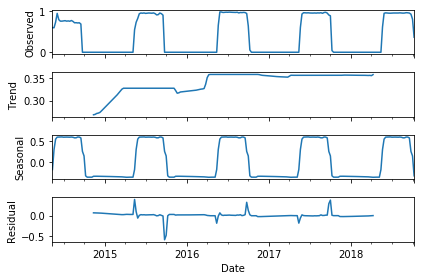

In [10]:
# observe seasonal decomposition graph
result = seasonal_decompose(moraine['PercentBooked'], model='additive')
fig = result.plot()

In [11]:
# plot time series in plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=moraine.index, y=moraine['PercentBooked'],
                mode='lines',
                name='lines'))

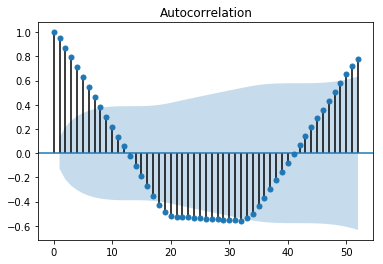

In [12]:
# autocorrelation plot
plot_acf(moraine['PercentBooked'], lags = 52);

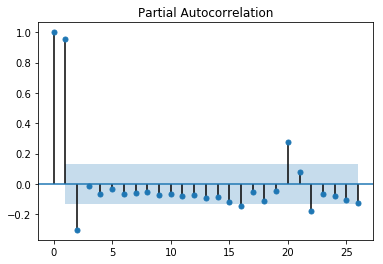

In [13]:
# partial autocorrelaion plot
plot_pacf(moraine['PercentBooked'], lags = 26);

In [15]:
# function to call various stationary tests in the pmdarima module
def stationary_tests(endog):
    # null hypothesis for ADF and KPSS is that the data is not stationary
    
    adf =  arima.ADFTest()
    print(f"P-value for Augmented Dickey-Fuller Test: {adf.should_diff(endog)[0]}")
    
    kpss =  arima.KPSSTest()
    print(f"P-value for Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test: {kpss.should_diff(endog)[0]}")
    
    # finds the differencing terms based on a 52 week seasonality component
    oscb =  arima.OCSBTest(52)
    print(f"Recommended diff for Osborn, Chui, Smith, and Birchenhall (OCSB) Test: {oscb.estimate_seasonal_differencing_term(endog)}")
    
    ch =  arima.CHTest(52)
    print(f"Recommended diff for Canova and Hansen Test: {ch.estimate_seasonal_differencing_term(endog)}")

In [16]:
stationary_tests(moraine['PercentBooked'])

P-value for Augmented Dickey-Fuller Test: 0.03055473818729153
P-value for Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test: 0.1
Recommended diff for Osborn, Chui, Smith, and Birchenhall (OCSB) Test: 0
Recommended diff for Canova and Hansen Test: 0


In [17]:
# train test split and assign engdogenous and exogenous variables
train, test = moraine[:170], moraine[170:]

y_train, y_test = train['PercentBooked'], test['PercentBooked']
exog_train = train[['Reservations', 'NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']]
exog_test = test[['Reservations', 'NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']]

In [18]:
# run log transformer
fit = log_transformer(y_train)

In [19]:
# call stepwise model fit and predict
stepwise_model, preds, conf_int = sarima_fit_predict(fit, test, 60)

C:\Users\templ\Anaconda3\envs\dsi\lib\site-packages\pmdarima\arima\auto.py:227: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=784.134, BIC=789.658, Fit time=0.161 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=782.071, BIC=793.120, Fit time=2.456 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=780.087, BIC=788.373, Fit time=0.326 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=781.165, BIC=792.214, Fit time=0.503 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=758.604, BIC=769.653, Fit time=2.304 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 0, 52); AIC=761.257, BIC=777.830, Fit

In [20]:
# update model on a test split for a 30 week obervation
fit_test = log_transformer(y_test)
new_preds, new_conf, newly_observed, still_test = sarima_update(fit_test, 30, stepwise_model)

In [21]:
# inverse transform predictions and variables
preds = log_transformer(preds, inverse = True)
new_preds = log_transformer(new_preds, inverse = True)
conf_int = log_transformer(conf_int, inverse = True)
new_conf = log_transformer(new_conf, inverse = True)
still_test = log_transformer(still_test, inverse = True)
newly_observed = log_transformer(newly_observed, inverse=True)

In [22]:
# function to plot 60 week and 30 week updated forecast
def series_forecast_plot(train, test, preds, conf_int, observed, val_preds, val_conf, val_test):
    fig, axes = plt.subplots(2, 1, figsize=(20, 12))
    
    # find x axis limit, number of samples in training set
    lim = train.shape[0] + test.shape[0]
    n_train = train.shape[0]
    x = np.arange(n_train + preds.shape[0])
    
    # plot 60 week forecast
    axes[0].plot(x[:n_train], train, alpha=0.75)
    axes[0].scatter(x[n_train:], preds, alpha=0.4, marker='o')
    axes[0].scatter(x[n_train:], test[:preds.shape[0]], alpha=0.4, marker='x')
    axes[0].fill_between(x[n_train:], conf_int[:, 0], conf_int[:, 1],
                         alpha=0.1, color='b')
    axes[0].set_title('Actual test samples vs. forecasts')
    axes[0].set_xlim((0, lim))
    
    # limits for 30 week forecast
    x2 = np.arange(lim)
    n_trained_on = n_train + newly_observed.shape[0]
    
    # plot 30 week forecast
    axes[1].plot(x2[:n_train], train, alpha=0.75)
    axes[1].plot(x2[n_train: n_trained_on], observed, alpha=0.75, c='orange')
    axes[1].scatter(x2[n_trained_on:], val_preds, alpha=0.4, marker='o')
    axes[1].scatter(x2[n_trained_on:], val_test, alpha=0.4, marker='x')
    axes[1].fill_between(x2[n_trained_on:], val_conf[:, 0], val_conf[:, 1],
                         alpha=0.1, color='b')
    axes[1].set_title('Updated test samples vs. forecasts')
    axes[1].set_xlim((0, lim))

    plt.show()

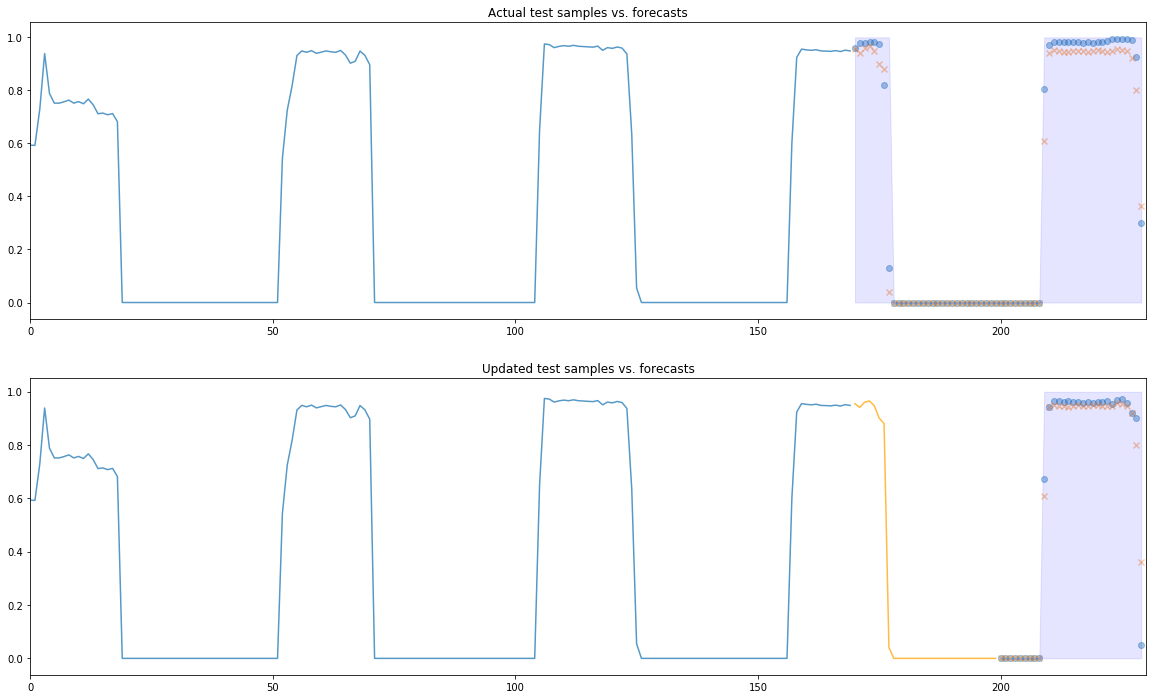

In [23]:
# plot forecasts
series_forecast_plot(y_train, y_test, preds, conf_int, newly_observed, new_preds, new_conf, still_test)

In [24]:
# plotly forecasts
plotly_forecast(moraine, preds, y_train, y_test, "Actual vs. Forecasted Percentage of Sites Booked: Moraine")

In [25]:
# 60 week predictions
time_series_metrics(preds, y_test)

Forecast Bias: -0.019257253686908046
MAE: 0.02341226850896706
RMSE: 0.04204713452287389


In [26]:
# 30 week updated predcitions
time_series_metrics(new_preds, still_test)

Forecast Bias: -0.0026623183955997885
MAE: 0.023488290247012964
RMSE: 0.0619787326144698


In [27]:
# fit on total samples and generate predicitons
fit  = log_transformer(moraine['PercentBooked'])
stepwise_model.fit(fit)
preds, conf_int = stepwise_model.predict(n_periods = 104, return_conf_int= True)
preds = log_transformer(preds, inverse = True)
conf_int = log_transformer(conf_int, inverse= True)

(200, 334)

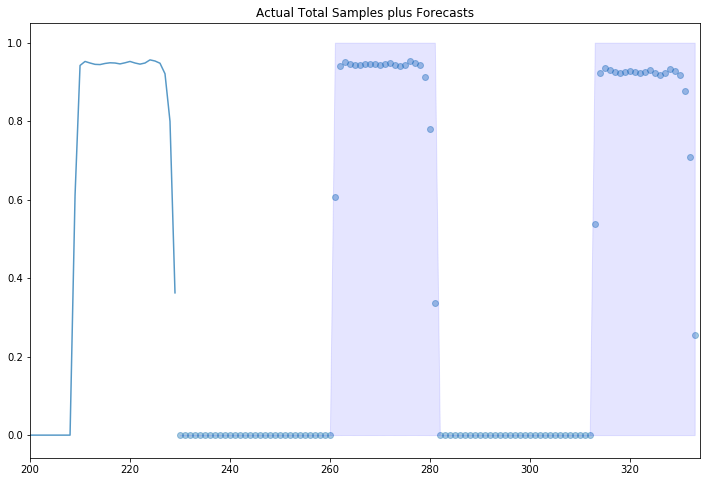

In [28]:
# plot 2 year unseen forecast
fig = plt.figure(figsize=(12, 8))

n_train = fit.shape[0]
x = np.arange(n_train + preds.shape[0])
plt.plot(x[:n_train], moraine['PercentBooked'], alpha=0.75)
plt.scatter(x[n_train:], preds, alpha=0.4, marker='o')
plt.fill_between(x[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')

plt.title('Actual Total Samples plus Forecasts')
plt.xlim((200, moraine.shape[0] + preds.shape[0]))

# Mather Campground, Grand Canyon National Park
---

Mather park exhibits rather stationary 52-week seasonality. The ADF test boasts a p-value of 0.0305, indicating that the data is stationary, but KPSS p-value of 0.1 indicates that the data has a unit-root present. However, both the OCSB and CH Test indicated no need for differencing.

  The SARIMA(3,1,2)(0,1,0)52 model on the Mather data was adequate in capturing its seasonality, but still saw significant error. It reported a RMSE of 24.50%  and a 12.69% MAE on a 60 week forecast. On the 30 week updated forecast, the model scored a RMSE of 22.32% and a MAE of 17.90%.

  Mather was an interesting case as each October sees a significant spike in booking percentage, often reaching 100% or higher. Mather's forecast was more bullish on its trend, which saw a significant increase in the 60 week forecast. However, on updating the model with 30 weeks of testing data, the model's projects dropped to indicating a decreasing trend.

In [29]:
mather = pd.read_csv( "../data/Site-Data/mather_agg.csv")

In [30]:
# load in mather dataset and set datetime index
mather['Date'] = pd.to_datetime(mather['Date']) - pd.to_timedelta(7, unit='d')
mather.index = pd.DatetimeIndex(mather['Date'])
mather = mather[mather.index < '2019-01-01']
mather = mather.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().sort_values('Date')
mather.head()

FacilityID  Reservations  NumberOfPeople  SitesBooked  AvgStayLen  \
Date                                                                            
2013-09-30    232490.0      0.333333        0.333333     0.333333    0.666667   
2013-10-07    232490.0     50.285714      119.142857    44.857143    1.028256   
2013-10-14    232490.0    175.571429      509.142857   147.428571    2.670648   
2013-10-21    232490.0    174.000000      457.857143   144.428571    2.804204   
2013-10-28    232490.0    112.000000      269.857143    99.571429    2.781567   

            AvgBookingHorizon  AverageFee  DailyRevenue      SumHor  \
Date                                                                  
2013-09-30           0.333333    6.000000      3.000000    0.333333   
2013-10-07           0.004900   10.084288    474.802037    0.714286   
2013-10-14           0.232833   26.653030   1695.064279   40.857142   
2013-10-21           1.019163   27.970174   1710.046596  181.142857   
2013-10-28           2.314576   28.747663   1142.918692  258.571425   

                SumLen       SumFee  SitesAvailable  PercentBooked  
Date                                                                
2013-09-30    0.666667     6.000000      118.666667       0.000934  
2013-10-07  121.285716  1188.000008      108.142857       0.125650  
2013-10-14  468.714290  4679.571433      209.571429       0.412965  
2013-10-21  487.857142  4869.428588      212.571429       0.404562  
2013-10-28  311.285716  3216.285692      257.428571       0.278912

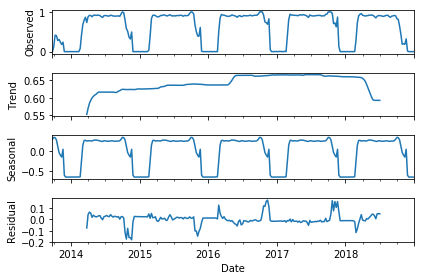

In [31]:
# seasonal decomposition plot
result = seasonal_decompose(mather['PercentBooked'], model='additive')
fig = result.plot()

In [32]:
# time series plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=mather.index, y=mather['PercentBooked'],
                mode='lines',
                name='lines'))

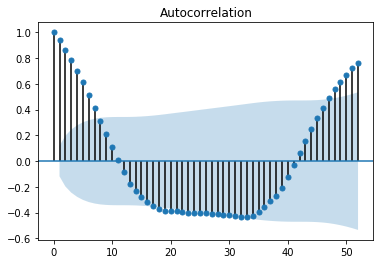

In [33]:
# autocorrelation plot
plot_acf(mather['PercentBooked'], lags = 52);

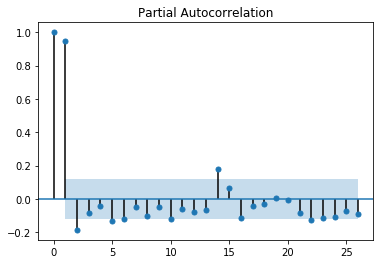

In [34]:
# partial autocorrelaion plot
plot_pacf(mather['PercentBooked'], lags = 26);

In [35]:
# run stationary test
stationary_tests(mather['PercentBooked'])

P-value for Augmented Dickey-Fuller Test: 0.01
P-value for Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test: 0.1
Recommended diff for Osborn, Chui, Smith, and Birchenhall (OCSB) Test: 0
Recommended diff for Canova and Hansen Test: 0


In [36]:
mather.shape

(275, 13)

In [37]:
# define train test split, exog and edog variables
train, test = mather[:215], mather[215:]

y_train, y_test = train['PercentBooked'], test['PercentBooked']
exog_mather = ['NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']

In [39]:
# log transform training data
fit = log_transformer(y_train)

In [40]:
# fit model and get predictions
stepwise_model, preds, conf_int = sarima_fit_predict(fit, test, 60)

C:\Users\templ\Anaconda3\envs\dsi\lib\site-packages\pmdarima\arima\auto.py:227: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=1103.256, BIC=1109.431, Fit time=0.202 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=1081.284, BIC=1093.635, Fit time=3.078 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=1080.235, BIC=1089.498, Fit time=0.322 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=1065.869, BIC=1078.219, Fit time=0.719 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=1045.109, BIC=1060.547, Fit time=2.638 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 1, 0, 52); AIC=1040.307, BIC=1

In [41]:
# transform testing data, run SARIMA update
fit_test = log_transformer(y_test)
new_preds, new_conf, newly_observed, still_test = sarima_update(fit_test, 30, stepwise_model)

In [42]:
# inverse transform variables
preds = log_transformer(preds, inverse = True)
new_preds = log_transformer(new_preds, inverse = True)
conf_int = log_transformer(conf_int, inverse = True)
new_conf = log_transformer(new_conf, inverse = True)
still_test = log_transformer(still_test, inverse = True)
newly_observed = log_transformer(newly_observed, inverse=True)

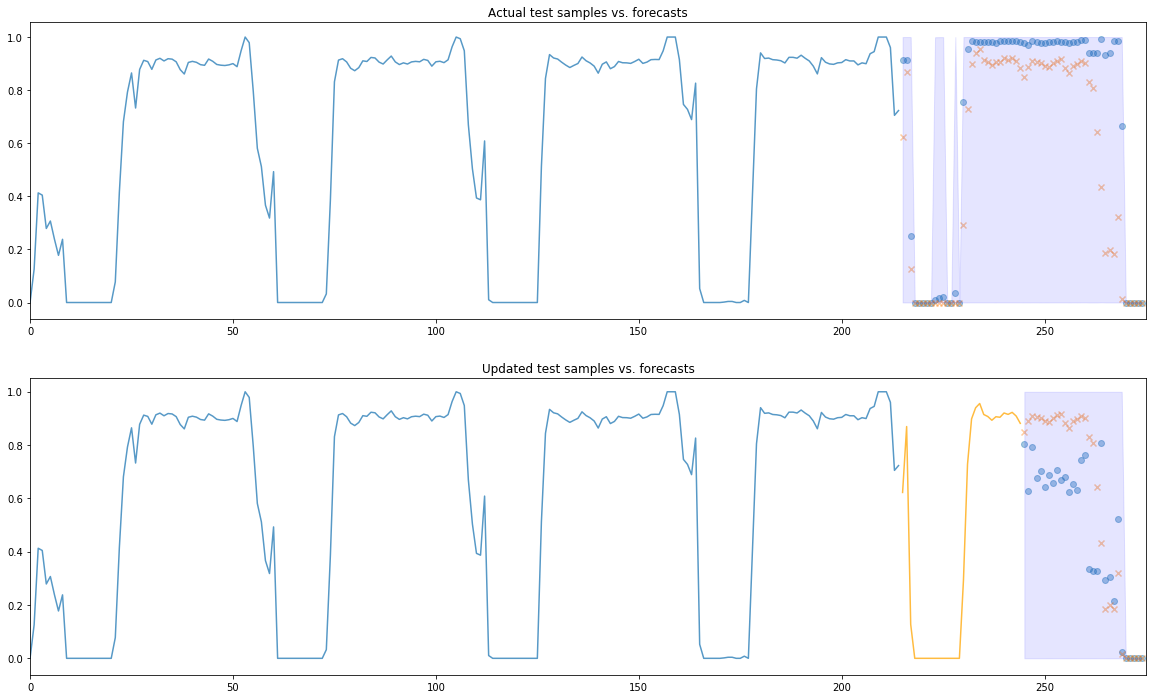

In [43]:
# forecast plots
series_forecast_plot(y_train, y_test, preds, conf_int, newly_observed, new_preds, new_conf, still_test)

In [44]:
# plotly forecasts
plotly_forecast(mather, preds, y_train, y_test, "Actual vs. Forecasted Percentage of Sites Booked: Mather")

In [45]:
# 60 week predictions
time_series_metrics(preds, y_test)

Forecast Bias: -0.1369760017276134
MAE: 0.13697600172761343
RMSE: 0.24500691058445356


In [46]:
# 30 week updated predcitions
time_series_metrics(new_preds, still_test)

Forecast Bias: 0.12390253913204673
MAE: 0.1790920558177545
RMSE: 0.22320842130583118


# Big Meadows Campground, Shenandoah National Park
---

Big Meadows was unique among the other sites as it's average booking percentage was lower than the others during its season, averaging 56.22% between May and October. The ADF test boasts a p-value of 0.064, indicating that the data may not be stationary, and KPSS p-value of 0.1 indicates that the data has a unit-root present. However, both the OCSB and CH Test indicated no need for differencing.

  The SARIMA(1,1,1)(1,1,0)52 model on the Big Meadow data captured it seasonality, but predicted a large uptick in booking. It reported a RMSE of 24.38%  and a 17.42% MAE on a 60 week forecast. On the 30 week updated forecast, the model scored a RMSE of 21.86% and a MAE of 17.90%.

  Big Meadows, being a the smallest and most Eastern of the campgrounds selected, is an interesting case in observing rising trends in park usage. Its seasonality looks stable, but sees sharp upticks in the late season, likely due to park visitors coming to see the fall foliage. The two year prediction especially looks volatile, but observes a trend of increased rate of reservations.

In [105]:
big_meadow = pd.read_csv( "../data/Site-Data/bigmeadow_agg.csv")

In [106]:
# load in big meadow dataset and set datetime index
big_meadow['Date'] = pd.to_datetime(big_meadow['Date']) - pd.to_timedelta(7, unit='d')
big_meadow.index = pd.DatetimeIndex(big_meadow['Date'])
big_meadow = big_meadow[big_meadow.index < '2019-01-01']
big_meadow = big_meadow.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().sort_values('Date')
big_meadow.head()

FacilityID  Reservations  NumberOfPeople  SitesBooked  AvgStayLen  \
Date                                                                            
2013-09-30    232459.0      0.500000        2.500000     0.500000    1.000000   
2013-10-07    232459.0      0.571429        3.428571     0.571429    0.571429   
2013-10-14    232459.0     13.571429       38.428571    13.428571    1.181791   
2013-10-21    232459.0     31.142857       82.142857    28.714286    3.153725   
2013-10-28    232459.0     56.000000      184.142857    53.571429    3.199183   

            AvgBookingHorizon  AverageFee  DailyRevenue      SumHor  \
Date                                                                  
2013-09-30           1.500000    0.000000      0.000000    1.500000   
2013-10-07           2.857143    0.000000      0.000000    5.714286   
2013-10-14           1.237851   12.784477    138.231295   34.428571   
2013-10-21           4.489710   33.828847    340.042520  136.857143   
2013-10-28           7.162628   32.432571    598.869049  415.857151   

                SumLen       SumFee  SitesAvailable  PercentBooked  
Date                                                                
2013-09-30    1.000000     0.000000      110.000000       0.002262  
2013-10-07    1.142857     0.000000       62.571429       0.002586  
2013-10-14   33.571429   354.285721       81.285714       0.060763  
2013-10-21   90.142857   952.857155      192.285714       0.129929  
2013-10-28  154.142860  1627.142860      167.428571       0.242405

In [129]:
# find averge booking for big meadows in peak season
np.mean([big_meadow[(big_meadow.index > '2018-05') & (big_meadow.index < '2018-11')]['PercentBooked'].mean(),
big_meadow[(big_meadow.index > '2017-05') & (big_meadow.index < '2017-11')]['PercentBooked'].mean(), 
        big_meadow[(big_meadow.index > '2016-05') & (big_meadow.index < '2016-11')]['PercentBooked'].mean(),
       big_meadow[(big_meadow.index > '2015-05') & (big_meadow.index < '2015-11')]['PercentBooked'].mean(),
       big_meadow[(big_meadow.index > '2014-05') & (big_meadow.index < '2014-11')]['PercentBooked'].mean()])

0.5622895448777802

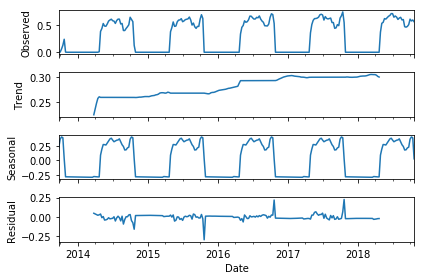

In [108]:
# seasonal decomposition plot
result = seasonal_decompose(big_meadow['PercentBooked'], model='additive')
fig = result.plot()

In [109]:
# timeseries in plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=big_meadow.index, y=big_meadow['PercentBooked'],
                mode='lines',
                name='lines'))

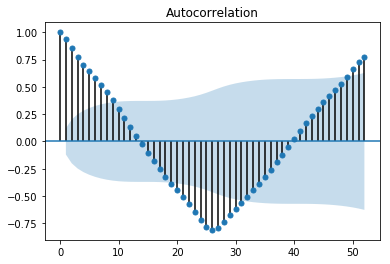

In [110]:
# autocorrelation plot
plot_acf(big_meadow['PercentBooked'], lags = 52);

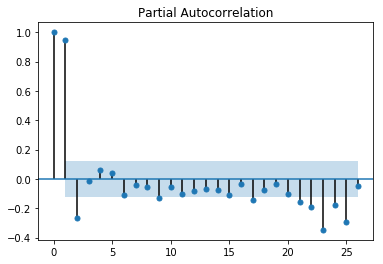

In [111]:
# partial autocorrelaion plot
plot_pacf(big_meadow['PercentBooked'], lags = 26);

In [112]:
# run stationary test
stationary_tests(big_meadow['PercentBooked'])

P-value for Augmented Dickey-Fuller Test: 0.06400468921464568
P-value for Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test: 0.1
Recommended diff for Osborn, Chui, Smith, and Birchenhall (OCSB) Test: 0
Recommended diff for Canova and Hansen Test: 0


In [113]:
big_meadow.columns

Index(['FacilityID', 'Reservations', 'NumberOfPeople', 'SitesBooked',
       'AvgStayLen', 'AvgBookingHorizon', 'AverageFee', 'DailyRevenue',
       'SumHor', 'SumLen', 'SumFee', 'SitesAvailable', 'PercentBooked'],
      dtype='object')

In [114]:
# train test split, define endog and exog
train, test = big_meadow[:205], big_meadow[205:]

y_train, y_test = train['PercentBooked'], test['PercentBooked']
exog_bm = train[['AvgStayLen', 'AvgBookingHorizon', 'AverageFee']].shift(1).dropna()

In [115]:
# transform training data
fit = log_transformer(y_train)

In [116]:
# run model and get predcitions
stepwise_model, preds, conf_int = sarima_fit_predict(fit, test, 60)

C:\Users\templ\Anaconda3\envs\dsi\lib\site-packages\pmdarima\arima\auto.py:227: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=1057.853, BIC=1063.901, Fit time=0.262 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=993.084, BIC=1005.180, Fit time=2.643 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=1019.035, BIC=1028.107, Fit time=0.362 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=1013.143, BIC=1022.214, Fit time=1.574 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=981.878, BIC=996.998, Fit ti

In [117]:
# transform test and update model
fit_test = log_transformer(y_test)
new_preds, new_conf, newly_observed, still_test = sarima_update(fit_test, 30, stepwise_model)

In [118]:
# inverser transform variables
preds = log_transformer(preds, inverse = True)
new_preds = log_transformer(new_preds, inverse = True)
conf_int = log_transformer(conf_int, inverse = True)
new_conf = log_transformer(new_conf, inverse = True)
still_test = log_transformer(still_test, inverse = True)
newly_observed = log_transformer(newly_observed, inverse=True)

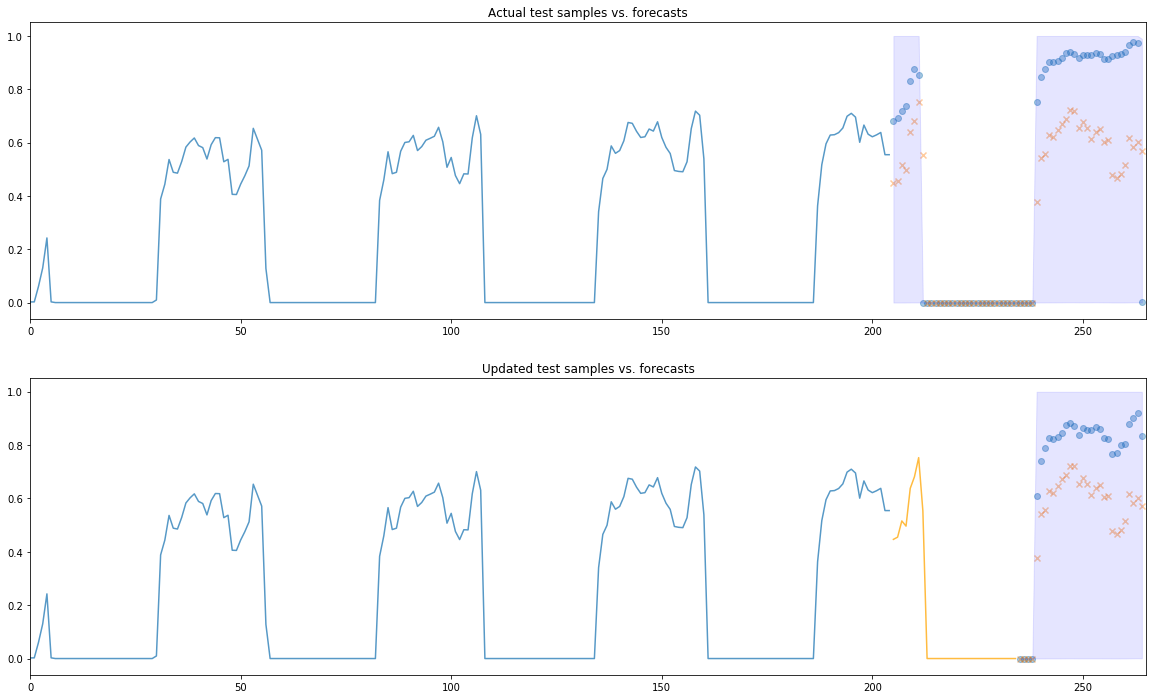

In [119]:
# plot forecasts
series_forecast_plot(y_train, y_test, preds, conf_int, newly_observed, new_preds, new_conf, still_test)

In [120]:
# plotly forecasts
plotly_forecast(big_meadow, preds, y_train, y_test, "Actual vs. Forecasted Percentage of Sites Booked: Big Meadows")

In [121]:
# 60 week predictions
time_series_metrics(preds, y_test)

Forecast Bias: -0.136828380463164
MAE: 0.1742122721585111
RMSE: 0.2438394222496759


In [122]:
# 30 week updated predictions
time_series_metrics(new_preds, still_test)

Forecast Bias: -0.19895961455492744
MAE: 0.19895961455492742
RMSE: 0.21860929746944158


In [123]:
# fit on total samples and generate predicitons
fit  = log_transformer(big_meadow['PercentBooked'])
stepwise_model.fit(fit)
preds, conf_int = stepwise_model.predict(n_periods = 104, return_conf_int= True)
preds = log_transformer(preds, inverse = True)
conf_int = log_transformer(conf_int, inverse= True)

(200, 369)

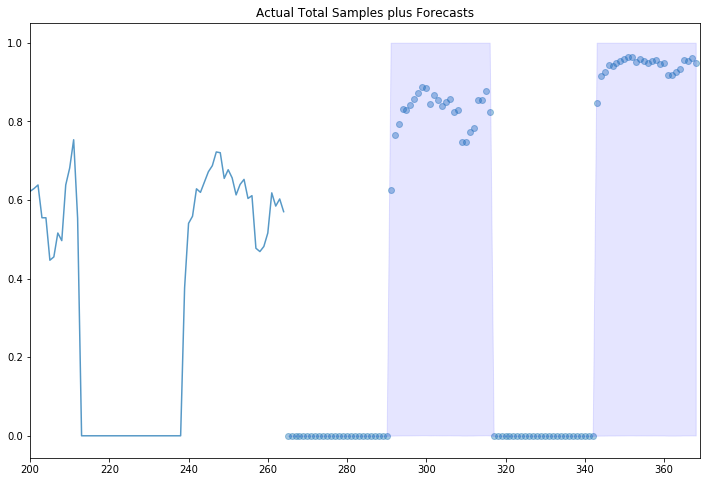

In [124]:
# plot 2 year unseen forecast
fig = plt.figure(figsize=(12, 8))

n_train = fit.shape[0]
x = np.arange(n_train + preds.shape[0])
plt.plot(x[:n_train], big_meadow['PercentBooked'], alpha=0.75)
plt.scatter(x[n_train:], preds, alpha=0.4, marker='o')
plt.fill_between(x[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')

plt.title('Actual Total Samples plus Forecasts')
plt.xlim((200, big_meadow.shape[0] + preds.shape[0]))

# Upper Pines Campground, Yosemite National Park
---

Upper Pines is opposed to Big Meadows in that it is by far the most popular campground in this analysis, boasting an average booking percentage of 98.02% during its peak season. The ADF test boasts a p-value of 0.014, indicating the data is stationary, and KPSS p-value of 0.1 indicates that the data has a unit-root present. However, both the OCSB and CH Test indicated no need for differencing.

  However, upon observation of the Upper Pines series, it becomes apparent that the campsite began to allow year round reservations in 2016, which required a different approach to modeling this data. A logarithmic transformation threw off the results dramatically, but incorporating exogenous variables into the model improved performance. I selected a lagged exogenous variable of the Average Stay Length, Average Booking Horizon, and the Average Fee for the SARIMAX model.

  The SARIMAX(1,1,1)(2,1,0)52 model was very accurate and captured the unique seasonality well. It reported a RMSE of 13.39%  and a 10.77% MAE on a 60 week forecast. On the 30 week updated forecast, the model scored a RMSE of 9.46% and a MAE of 7.84%.

  Upper Pines was a very unique case, but adapting my modeling approach to use lagged exogenous gave my forecast more accuracy an power. However, the two year forecast was not as convincing, showing a sharp decrease in booking and even significant negative values. This is a disadvantage of not using the logarithmic transformation, and indicates the exogenous factor could have been overfit to the model.

In [130]:
upper_pines = pd.read_csv( "../data/Site-Data/upperpines_agg.csv")

In [131]:
# load in upper pines dataset and set datetime index
upper_pines['Date'] = pd.to_datetime(upper_pines['Date']) - pd.to_timedelta(7, unit='d')
upper_pines.index = pd.DatetimeIndex(upper_pines['Date'])
upper_pines = upper_pines[upper_pines.index < '2019-01-01']
upper_pines = upper_pines.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().sort_values('Date')
upper_pines.head()

FacilityID  Reservations  NumberOfPeople  SitesBooked  AvgStayLen  \
Date                                                                            
2013-09-30    232447.0      1.000000        3.000000     1.000000    0.666667   
2013-10-07    232447.0      0.428571        0.857143     0.428571    1.285714   
2013-10-14    232447.0     76.285714      145.857143    61.714286    1.925305   
2013-10-21    232447.0    180.285714      347.142857   136.714286    3.046735   
2013-10-28    232447.0    162.000000      408.857143   132.142857    3.448719   

            AvgBookingHorizon  AverageFee  DailyRevenue      SumHor  \
Date                                                                  
2013-09-30           0.333333    4.444444      6.666667    1.000000   
2013-10-07           3.000000    0.000000      0.000000    3.000000   
2013-10-14           0.555215   19.796399    787.204065   79.142857   
2013-10-21           2.239072   33.009827   1931.050991  358.428571   
2013-10-28           4.974581   36.812322   1791.896240  854.285708   

                SumLen       SumFee  SitesAvailable  PercentBooked  
Date                                                                
2013-09-30    2.000000    13.333333       78.333333       0.004202  
2013-10-07    1.285714     0.000000      101.571429       0.001801  
2013-10-14  219.285716  2331.428536      108.285714       0.259304  
2013-10-21  552.857150  6041.428649      101.285714       0.574430  
2013-10-28  553.714285  5951.428623      105.857143       0.555222

In [132]:
# find averge booking for upper pines in peak season
np.mean([upper_pines[(upper_pines.index > '2018-05') & (upper_pines.index < '2018-11')]['PercentBooked'].mean(),
upper_pines[(upper_pines.index > '2017-05') & (upper_pines.index < '2017-11')]['PercentBooked'].mean(), 
        upper_pines[(upper_pines.index > '2016-05') & (upper_pines.index < '2016-11')]['PercentBooked'].mean(),
       upper_pines[(upper_pines.index > '2015-05') & (upper_pines.index < '2015-11')]['PercentBooked'].mean(),
       upper_pines[(upper_pines.index > '2014-05') & (upper_pines.index < '2014-11')]['PercentBooked'].mean()])

0.980277923135066

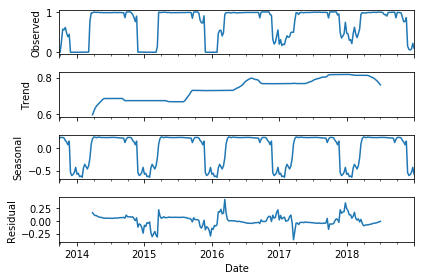

In [133]:
# view seaosnal decomposition plot
result = seasonal_decompose(upper_pines['PercentBooked'], model='additive')
fig = result.plot()

In [67]:
# plot time series
fig = go.Figure()
fig.add_trace(go.Scatter(x=upper_pines.index, y=upper_pines['PercentBooked'],
                mode='lines',
                name='lines'))

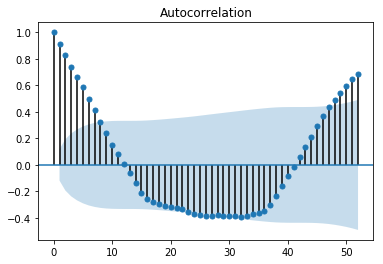

In [68]:
# autocorrelation plot
plot_acf(upper_pines['PercentBooked'], lags = 52);

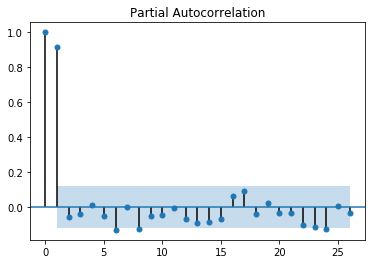

In [69]:
# partial autocorrelaion plot
plot_pacf(upper_pines['PercentBooked'], lags = 26);

In [134]:
# run stationary test
stationary_tests(upper_pines['PercentBooked'])

P-value for Augmented Dickey-Fuller Test: 0.014522443309564679
P-value for Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test: 0.1
Recommended diff for Osborn, Chui, Smith, and Birchenhall (OCSB) Test: 0
Recommended diff for Canova and Hansen Test: 0


In [70]:
upper_pines.shape

(275, 13)

In [71]:
# train test split, define endog and exog
train, test = upper_pines[:215], upper_pines[215:]

y_train, y_test = train['PercentBooked'], test['PercentBooked']
exog_up = train[['AvgStayLen', 'AvgBookingHorizon', 'AverageFee']].shift(1).dropna()

In [72]:
stepwise_model, preds, conf_int = sarima_fit_predict(y_train[1:], test, 60, exog = exog_up)

C:\Users\templ\Anaconda3\envs\dsi\lib\site-packages\pmdarima\arima\auto.py:227: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=-202.180, BIC=-186.773, Fit time=1.714 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=-214.030, BIC=-192.461, Fit time=29.464 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=-209.842, BIC=-191.353, Fit time=3.351 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 52); AIC=-221.395, BIC=-196.744, Fit time=58.844 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 52); AIC=-216.246, BIC=-194.677, Fit time=27.770 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 52); AIC=-226.154, BIC=-198.422, Fit time=59.196 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 0, 52); AIC

In [73]:
# update model on testing data
new_preds, new_conf, newly_observed, still_test = sarimax_update(y_test, test, 30, stepwise_model, exog_cols = exog_bm.columns)

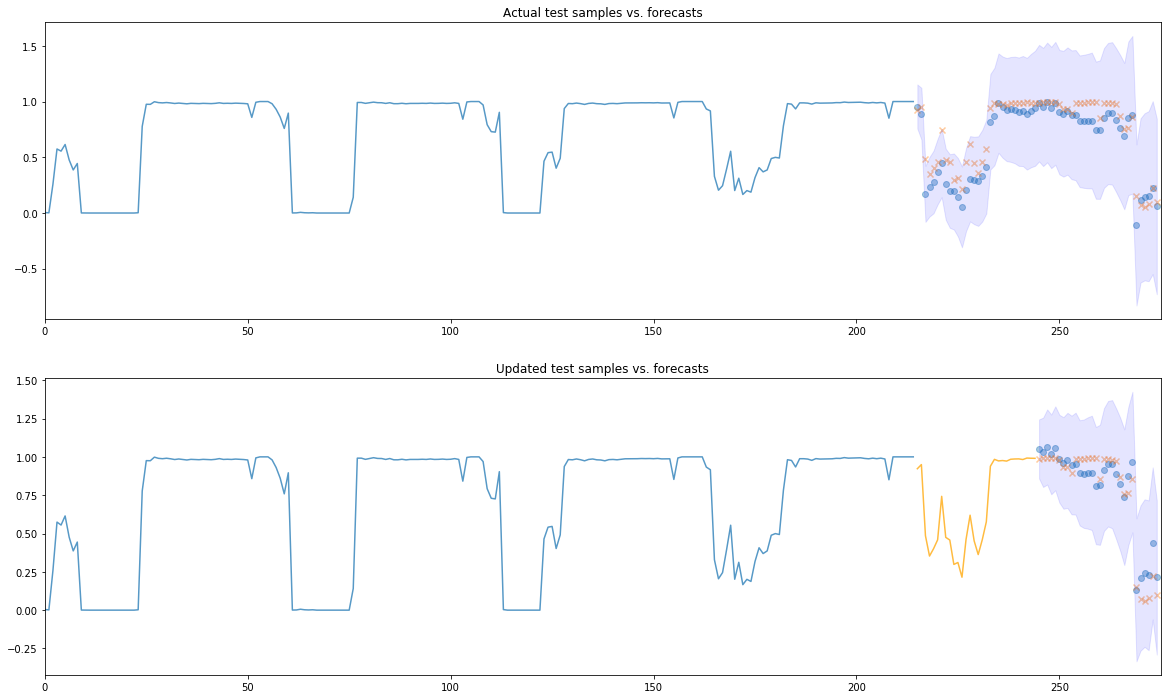

In [74]:
# plot forecasts
series_forecast_plot(y_train, y_test, preds, conf_int, newly_observed, new_preds, new_conf, still_test)

In [75]:
# plotly forecasts
plotly_forecast(big_meadow, preds, y_train, y_test, "Actual vs. Forecasted Percentage of Sites Booked: Upper Pines")

In [76]:
# 60 week predictions
time_series_metrics(preds, y_test)

Forecast Bias: 0.09561545558055533
MAE: 0.10769973377699463
RMSE: 0.1339701407227617


In [77]:
# 30 week updated predictions
time_series_metrics(new_preds, still_test)

Forecast Bias: -0.01540849089180282
MAE: 0.07841101916406462
RMSE: 0.09464665033565794


In [78]:
# fit on total samples and generate predicitons
stepwise_model.fit(upper_pines['PercentBooked'], exogenous= upper_pines[exog_up.columns])
preds, conf_int = stepwise_model.predict(n_periods = 104, exogenous= upper_pines[exog_up.columns][171:], return_conf_int= True)

(200, 379)

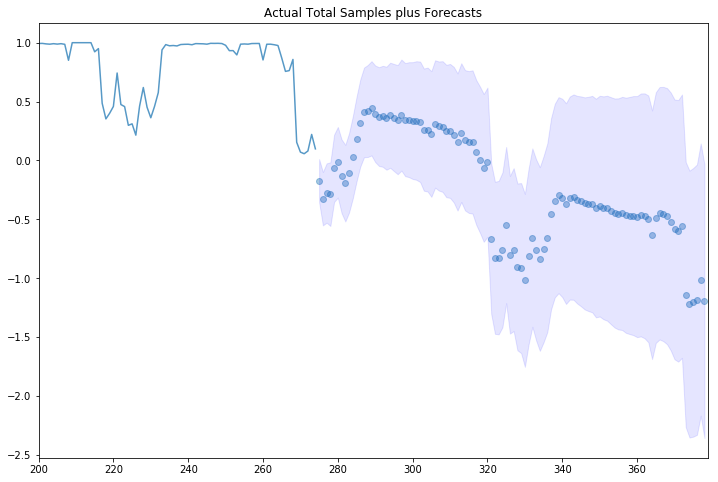

In [79]:
# plot two year forecast
fig = plt.figure(figsize=(12, 8))

n_train = upper_pines['PercentBooked'].shape[0]
x = np.arange(n_train + preds.shape[0])
plt.plot(x[:n_train], upper_pines['PercentBooked'], alpha=0.75)
plt.scatter(x[n_train:], preds, alpha=0.4, marker='o')
plt.fill_between(x[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')

plt.title('Actual Total Samples plus Forecasts')
plt.xlim((200, upper_pines.shape[0] + preds.shape[0]))

# Elkmont Campground, Great Smoky Mountains National Park
---

Elkmont was more traditional in its seasonality compared to Big Meadows and Upper Pines. The ADF test boasts a p-value of 0.033, indicating the data is stationary, and KPSS p-value of 0.1 indicates that the data has a unit-root present. However, both the OCSB and CH Test indicated no need for differencing. I again used logarithmic transformation on the Elkmont endogenous variable to limit predictions.

   The SARIMA(2,1,1)(0,1,0)52 model was accurate and captured some unique trends. It reported a RMSE of 10.77%  and a 5.9% MAE on a 60 week forecast. On the 30 week updated forecast, the model scored a RMSE of 11.35% and a MAE of 7.9%.

  Elkmont is a very popular campground that, like Big Meadows, sees a sharp uptick in the late season likely due to changing foliage and milder weather. The two year forecast was able to effectively capture this trend.

In [135]:
elkmont = pd.read_csv( "../data/Site-Data/elkmont_agg.csv")

In [136]:
# load in elkmont dataset and set datetime index
elkmont['Date'] = pd.to_datetime(elkmont['Date']) - pd.to_timedelta(7, unit='d')
elkmont.index = pd.DatetimeIndex(elkmont['Date'])
elkmont = elkmont[elkmont.index < '2019-01-01']
elkmont = elkmont.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().sort_values('Date')
elkmont.head()

FacilityID  Reservations  NumberOfPeople  SitesBooked  AvgStayLen  \
Date                                                                            
2013-10-07    232487.0      0.500000        1.500000     0.500000    1.000000   
2013-10-14    232487.0     43.142857       98.571429    36.714286    2.613704   
2013-10-21    232487.0     92.857143      209.000000    75.428571    3.646477   
2013-10-28    232487.0     36.285714       85.857143    32.428571    2.111041   
2013-11-04    232487.0      0.000000        0.000000     0.000000    0.000000   

            AvgBookingHorizon  AverageFee  DailyRevenue      SumHor  \
Date                                                                  
2013-10-07           5.000000    0.000000      0.000000    5.000000   
2013-10-14           0.819593   27.310174    440.841144   52.571429   
2013-10-21           3.045552   37.368877    974.759696  297.999995   
2013-10-28           1.703865   21.367089    365.899144  106.571430   
2013-11-04           0.000000    0.000000      0.000000    0.000000   

                SumLen       SumFee  SitesAvailable  PercentBooked  
Date                                                                
2013-10-07    1.000000     0.000000      105.500000       0.002358  
2013-10-14  136.285714  1424.857136      145.000000       0.173181  
2013-10-21  334.142853  3427.714320      136.571429       0.355795  
2013-10-28  134.428572  1362.571459       88.714286       0.152965  
2013-11-04    0.000000     0.000000        0.000000       0.000000

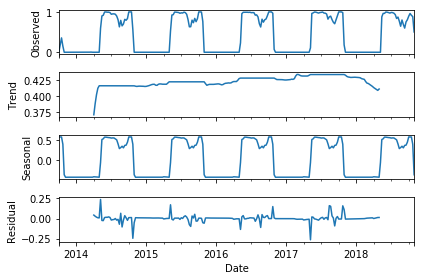

In [137]:
# plot seasonal decomposition graph
result = seasonal_decompose(elkmont['PercentBooked'], model='additive')
fig = result.plot()

In [138]:
# plot time series
fig = go.Figure()
fig.add_trace(go.Scatter(x=elkmont.index, y=elkmont['PercentBooked'],
                mode='lines',
                name='lines'))

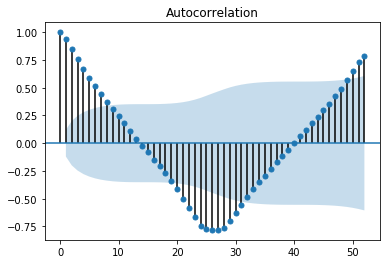

In [139]:
# autocorrelation plot
plot_acf(elkmont['PercentBooked'], lags = 52);

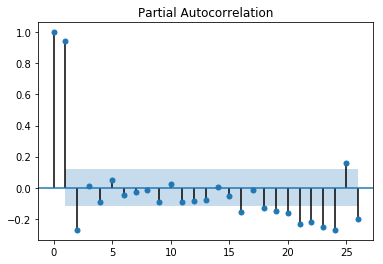

In [140]:
# partial autocorrelation plot
plot_pacf(elkmont['PercentBooked'], lags = 26);

In [142]:
# run stationary test
stationary_tests(elkmont['PercentBooked'])

P-value for Augmented Dickey-Fuller Test: 0.03282276708187835
P-value for Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test: 0.1
Recommended diff for Osborn, Chui, Smith, and Birchenhall (OCSB) Test: 0
Recommended diff for Canova and Hansen Test: 0


In [86]:
elkmont.shape

(265, 13)

In [87]:
# train, test split, define endog and exog
train, test = elkmont[:205], elkmont[205:]

y_train, y_test = train['PercentBooked'], test['PercentBooked']
exog_elk = ['NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']

In [88]:
# transform endog
fit = log_transformer(y_train)

In [89]:
# fit and predict
stepwise_model, preds, conf_int = sarima_fit_predict(fit, test, 60)

C:\Users\templ\Anaconda3\envs\dsi\lib\site-packages\pmdarima\arima\auto.py:227: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=944.170, BIC=950.218, Fit time=0.227 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=940.523, BIC=952.619, Fit time=2.551 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=938.791, BIC=947.862, Fit time=0.371 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=917.163, BIC=929.258, Fit time=0.679 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=888.326, BIC=903.446, Fit time=2.640 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 1, 0, 52); AIC=890.601, BIC=911.768, Fit

In [90]:
# transform test and update model
fit_test = log_transformer(y_test)
new_preds, new_conf, newly_observed, still_test = sarima_update(fit_test, 30, stepwise_model)

In [91]:
# inverse transform variables
preds = log_transformer(preds, inverse = True)
new_preds = log_transformer(new_preds, inverse = True)
conf_int = log_transformer(conf_int, inverse = True)
new_conf = log_transformer(new_conf, inverse = True)
still_test = log_transformer(still_test, inverse = True)
newly_observed = log_transformer(newly_observed, inverse=True)

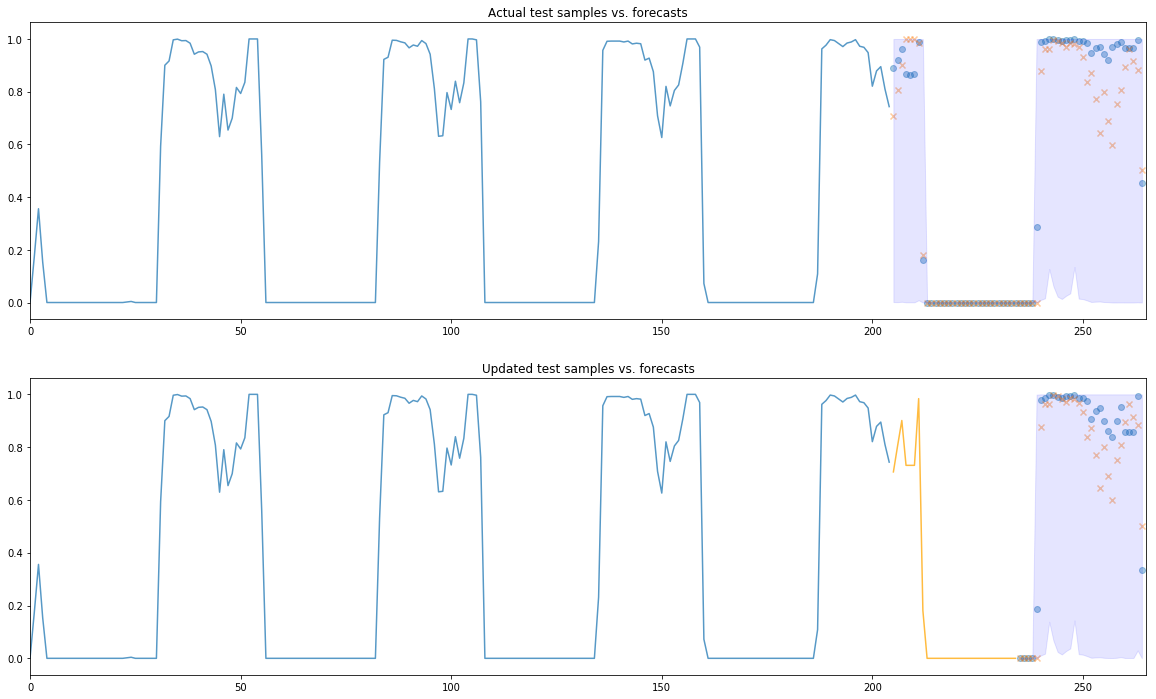

In [92]:
# plot forecasts
series_forecast_plot(y_train, y_test, preds, conf_int, newly_observed, new_preds, new_conf, still_test)

In [93]:
# plotly forecasts
plotly_forecast(elkmont, preds, y_train, y_test, "Actual vs. Forecasted Percentage of Sites Booked: Elkmont")

In [94]:
preds.shape

(60,)

In [95]:
# 60 week predictions
time_series_metrics(preds, y_test)

Forecast Bias: -0.04380255853838958
MAE: 0.05959541085292405
RMSE: 0.1077667695251611


In [96]:
# 30 week updated predictions
time_series_metrics(new_preds, still_test)

Forecast Bias: -0.05505181755694471
MAE: 0.0795795183724526
RMSE: 0.11350141648857745


In [97]:
# fit on total samples and generate predicitons
fit  = log_transformer(elkmont['PercentBooked'])
stepwise_model.fit(fit)
preds, conf_int = stepwise_model.predict(n_periods = 104, return_conf_int= True)
preds = log_transformer(preds, inverse = True)
conf_int = log_transformer(conf_int, inverse= True)

(200, 369)

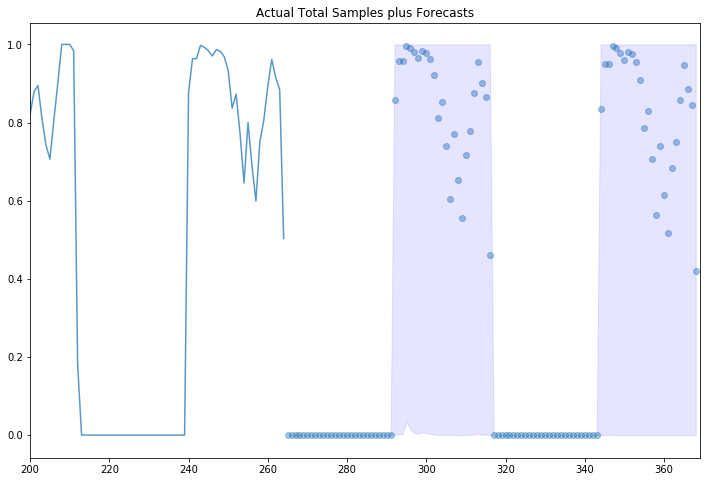

In [98]:
# plot two year predictions
fig = plt.figure(figsize=(12, 8))

n_train = fit.shape[0]
x = np.arange(n_train + preds.shape[0])
plt.plot(x[:n_train], elkmont['PercentBooked'], alpha=0.75)
plt.scatter(x[n_train:], preds, alpha=0.4, marker='o')
plt.fill_between(x[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')

plt.title('Actual Total Samples plus Forecasts')
plt.xlim((200, elkmont.shape[0] + preds.shape[0]))